In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy.stats as stats
import itertools as itertls

from tqdm import notebook
from typing import Union

from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [30]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [31]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=2)
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)

## Pre-processing

In [32]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [33]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [34]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,21
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,46
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,44


*Encoding*

In [35]:
df_cdb_enc = df_cdb_with_tipe.copy()

categorical_features = ["Kelurahan", "Kecamatan", "Gender", "Pekerjaan", "Pengeluaran", "Pendidikan", "initial Varian Plus", "Tipe Pembeli"]

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_cdb_enc[col] = le.fit_transform(df_cdb_enc[col])
    label_encoders[col] = le

df_cdb_enc

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,41,3,0,1996-08-18,18,3,5,LD0,4,0,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,51,7,1,2003-04-14,10,0,0,LP0,4,0,21
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,204,5,1,1997-02-13,14,6,2,LPA,4,0,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,212,4,1,1982-11-16,9,5,4,LP0,4,0,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,43,4,0,1976-01-17,10,4,4,LPA,4,0,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,116,6,0,2004-11-06,10,6,4,MM0,5,0,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,51,7,1,1978-03-21,10,3,4,MM0,5,0,46
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,71,5,0,1961-01-19,10,3,2,LP3,4,0,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,212,4,1,1980-04-30,2,2,4,ML0,5,0,44


In [36]:
label_mappings = []

for col, le in label_encoders.items():
    for index, class_name in enumerate(le.classes_):
        label_mappings.append({"Fitur": col, "Encoded Value": index, "Original Label": class_name})

df_label_mappings = pd.DataFrame(label_mappings)
df_label_mappings.to_csv("label_enc.csv", index=False)

*Group Data by Week For Each Month*

In [37]:
df_cdb_enc["Tgl. Mohon"] = pd.to_datetime(df_cdb_enc["Tgl. Mohon"])

df_cdb_enc["Year"] = df_cdb_enc["Tgl. Mohon"].dt.isocalendar().year
df_cdb_enc["Week"] = df_cdb_enc["Tgl. Mohon"].dt.isocalendar().week

df_cdb_week = df_cdb_enc.groupby(["Year", "Week"]).agg({
    "Nama": "count",
    "Kelurahan": "mean",
    "Kecamatan": "mean",
    "Gender": "mean",
    "Pekerjaan": "mean",  
    "Pengeluaran": "mean",
    "Pendidikan": "mean",
    "Tipe Pembeli": "mean",
    "Umur": "mean"
}).reset_index()

df_cdb_week.rename(columns={"Nama": "Total Sales"}, inplace=True)

varian_counts = df_cdb_enc.groupby(["Year", "Week"])["initial Varian Plus"].value_counts().unstack(fill_value=0).reset_index()

df_cdb_week = df_cdb_week.merge(varian_counts, on=["Year", "Week"], how="left")

date_range = pd.date_range(start="2021-02-01", end="2024-08-31", freq="W-MON")
df_all_weeks = pd.DataFrame({"Date": date_range})
df_all_weeks["Year"] = df_all_weeks["Date"].dt.isocalendar().year
df_all_weeks["Week"] = df_all_weeks["Date"].dt.isocalendar().week
df_all_weeks = df_all_weeks.drop(columns=["Date"])

df_cdb_week = df_all_weeks.merge(df_cdb_week, on=["Year", "Week"], how="left").fillna(0)
df_cdb_week.to_csv("CDB_week.csv", index=False)
df_cdb_week

,Year,Week,Total Sales,Kelurahan,Kecamatan,Gender,Pekerjaan,Pengeluaran,Pendidikan,Tipe Pembeli,Umur,0,1,2,3,4,5
0,2021,5,10,120.000000,4.200000,0.400000,9.600000,3.200000,3.200000,0.000000,35.500000,1,0,4,0,5,0
1,2021,6,27,112.592593,6.888889,0.555556,10.074074,2.962963,3.481481,0.000000,42.518519,1,0,7,0,19,0
2,2021,7,19,121.315789,11.105263,0.421053,13.842105,2.789474,3.157895,0.000000,43.578947,0,0,4,1,14,0
3,2021,8,30,101.400000,6.366667,0.500000,10.966667,3.533333,3.700000,0.066667,40.600000,3,1,6,0,20,0
4,2021,9,20,113.050000,9.550000,0.300000,11.900000,3.550000,3.800000,0.000000,41.900000,0,0,5,0,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2024,31,44,113.181818,4.636364,0.500000,7.431818,3.272727,3.840909,0.022727,38.340909,0,1,0,0,23,20
183,2024,32,55,106.836364,5.690909,0.454545,8.236364,3.563636,3.836364,0.000000,38.818182,0,1,1,0,23,30
184,2024,33,38,99.763158,4.710526,0.526316,7.552632,3.157895,3.552632,0.000000,36.710526,0,0,0,0,19,19
185,2024,34,48,95.166667,5.562500,0.500000,8.270833,3.145833,3.770833,0.000000,37.187500,0,4,0,0,23,21


Visualisasi

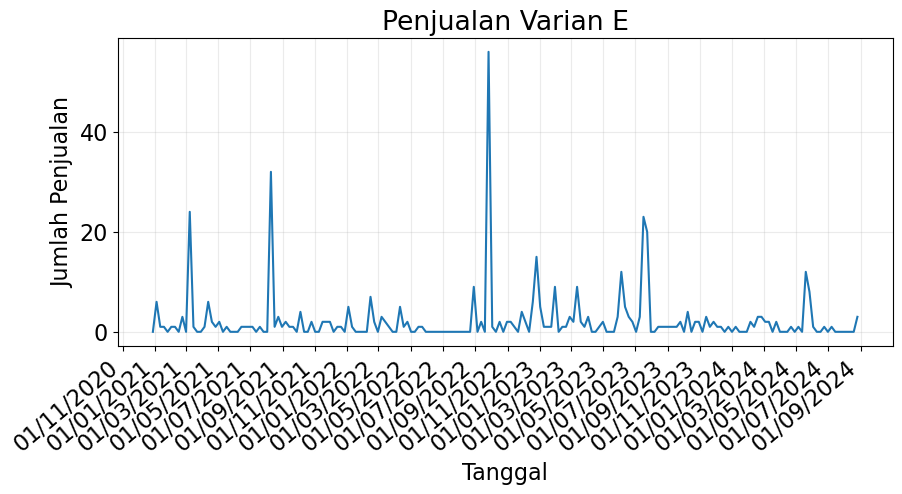

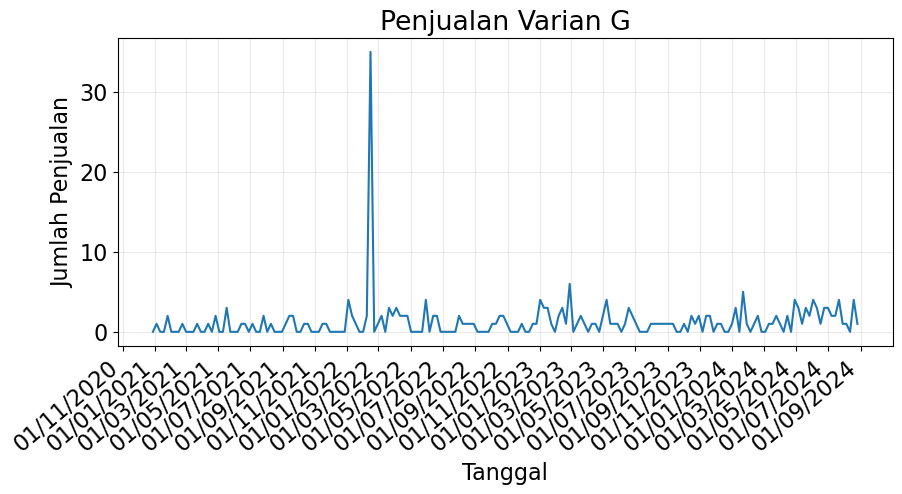

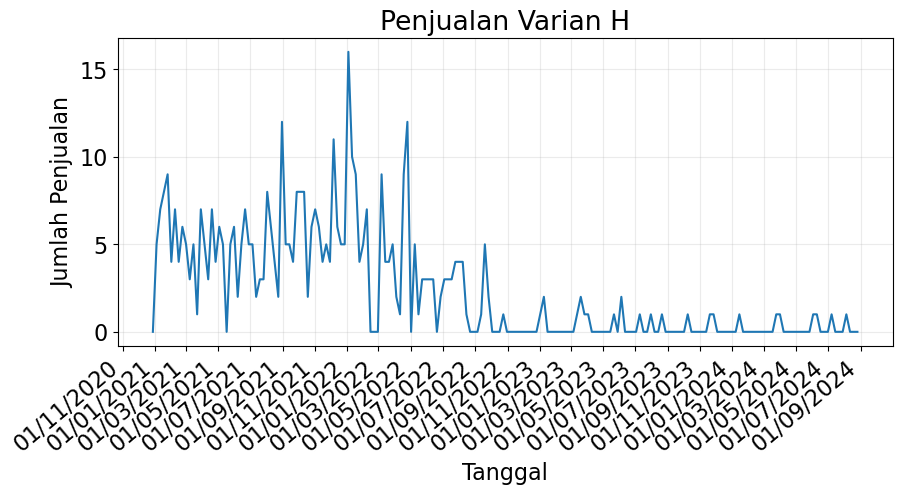

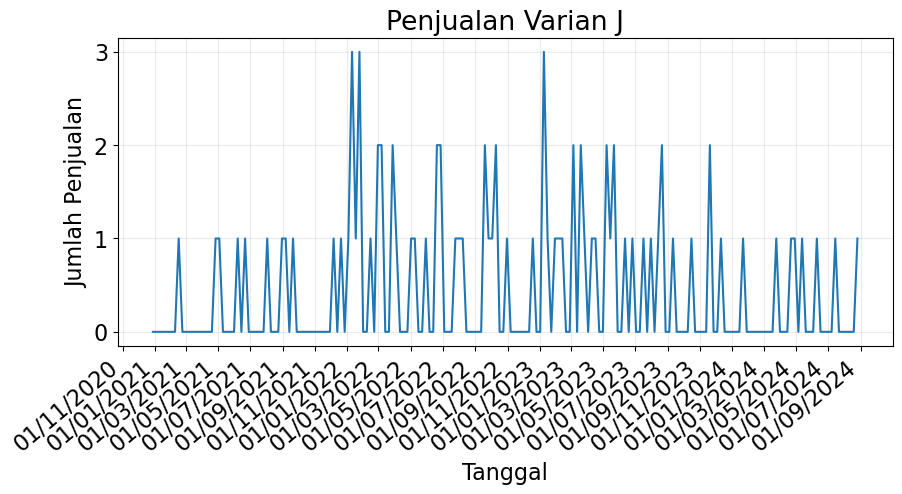

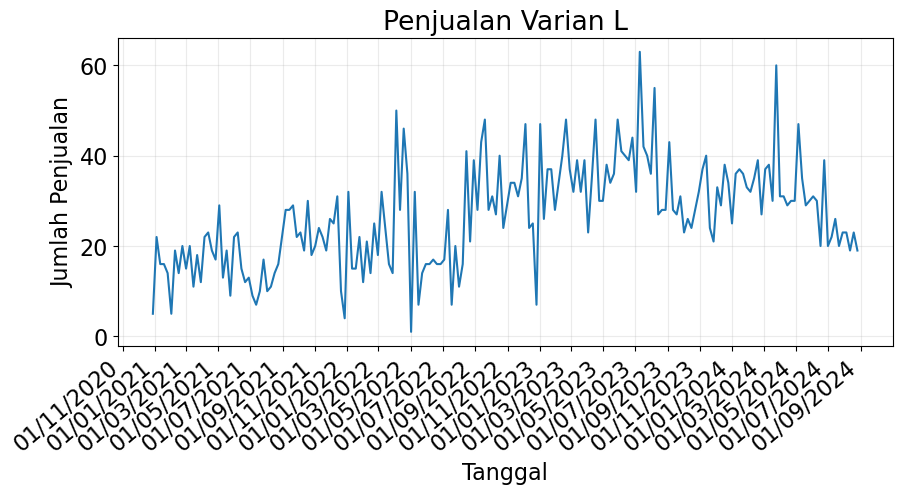

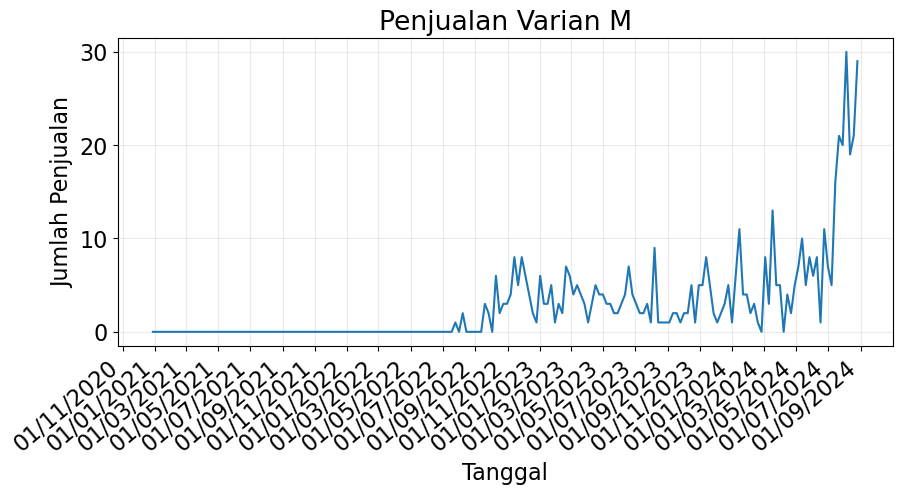

In [38]:
varian_mapping = {0: "E", 1: "G", 2: "H", 3: "J", 4: "L", 5: "M"}
df_cdb_enc["Varian Label"] = df_cdb_enc["initial Varian Plus"].map(varian_mapping)

df_weekly_varian = df_cdb_enc.groupby(["Year", "Week", "Varian Label"]).size().unstack(fill_value=0).reset_index()
df_weekly_varian["Date"] = pd.to_datetime(df_weekly_varian["Year"].astype(str) + df_weekly_varian["Week"].astype(str) + '1', format='%G%V%w')

for varian in ["E", "G", "H", "J", "L", "M"]:
    if varian in df_weekly_varian.columns:
        plot_time_series(df_weekly_varian["Date"], df_weekly_varian[varian], 
                         xlabel="Tanggal", ylabel="Jumlah Penjualan", 
                         title=f"Penjualan Varian {varian}")

## EDA

#### Test korelasi
fitur numerik :
- umur 

fitur kategorikal :
1. nominal, tidak memiliki urutan atau ranking
2. ordinal, memiliki urutan atau ranking
- kelurahan (nominal)
- kecamatan (nominal)
- gender (nominal)
- pekerjaan (nominal)
- pengeluaran (ordinal)
- pendidikan (ordinal)
- tipe pembeli (nominal)

korelasi yang digunakan terhadap fitur initial varian (kategorikal)
- umur → Pearson
- kelurahan → Chi-Square
- kecamatan → Chi-Square
- gender → Chi-Square
- pekerjaan → Chi-Square
- pengeluaran → Spearman
- pendidikan → Spearman
- tipe pembeli → Chi-Square

1. Pearson

In [39]:
pearson_corr, p_value = stats.pearsonr(df_cdb_enc["Umur"], df_cdb_enc["initial Varian Plus"])

print(f"Pearson (r): {pearson_corr:.4f}")
print(f"P-value: {p_value:.4f}")

if 0.01 <= pearson_corr <= 1:
    interpretation = "Hubungan positif"
elif pearson_corr == 0:
    interpretation = "Tidak ada hubungan linear"
elif -1 <= pearson_corr < -0.01:
    interpretation = "Hubungan negatif"
else:
    interpretation = "Nilai di luar rentang yang diharapkan."

print(f"Interpretasi: {interpretation}")

if p_value < 0.05:
    print("Hasil signifikan: Ada hubungan antara Umur dan Initial Varian Plus.")
else:
    print("Hasil tidak signifikan: Tidak ada hubungan antara Umur dan Initial Varian Plus.")

Pearson (r): 0.0497
P-value: 0.0000
Interpretasi: Hubungan positif
Hasil signifikan: Ada hubungan antara Umur dan Initial Varian Plus.


2. Spearman

In [40]:
spearman_pengeluaran, p_value_pengeluaran = stats.spearmanr(df_cdb_enc["Pengeluaran"], df_cdb_enc["initial Varian Plus"])
spearman_pendidikan, p_value_pendidikan = stats.spearmanr(df_cdb_enc["Pendidikan"], df_cdb_enc["initial Varian Plus"])

def interpret_spearman(corr, p_value, feature_name):
    if 1 >= corr >= 0.5:
        interpretation = "Hubungan positif"
    elif -1 <= corr <= -0.5:
        interpretation = "Hubungan negatif"
    elif 0.5 > corr > -0.5:
        interpretation = "Hubungan lemah atau tidak signifikan"
    else:
        interpretation = "Tidak ada hubungan monotonic yang signifikan"

    signifikan = "signifikan" if p_value < 0.05 else "tidak signifikan"

    print(f"{feature_name}:")
    print(f"Spearman (rs): {corr:.4f}")
    print(f"p-value: {p_value:.4f} ({signifikan})")
    print(f"{interpretation} antara {feature_name} dan Initial Varian Plus\n")

interpret_spearman(spearman_pengeluaran, p_value_pengeluaran, "Pengeluaran")
interpret_spearman(spearman_pendidikan, p_value_pendidikan, "Pendidikan")


Pengeluaran:
Spearman (rs): -0.1666
p-value: 0.0000 (signifikan)
Hubungan lemah atau tidak signifikan antara Pengeluaran dan Initial Varian Plus

Pendidikan:
Spearman (rs): -0.1773
p-value: 0.0000 (signifikan)
Hubungan lemah atau tidak signifikan antara Pendidikan dan Initial Varian Plus



maka pengeluaran dan pendidikan memiliki sedikit hubungan, tetapi tidak cukup kuat untuk dianggap pola yang konsisten (tidak signifikan)

3. Chi-Square

In [41]:
chi_square_features = ["Kelurahan", "Kecamatan", "Gender", "Pekerjaan", "Tipe Pembeli"]

def chi_square_test(feature, df_cdb_enc):
    contingency_table = pd.crosstab(df_cdb_enc[feature], df_cdb_enc["initial Varian Plus"])
    
    # uji chi-square
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"\nFeature: {feature}")
    # print("Contingency Table:\n", contingency_table)
    # print("Observed Values:\n", contingency_table.values)
    # print("Expected Values:\n", expected)
    
    # critical value pada alpha 0.05
    signifikan = 0.05
    critical_value = stats.chi2.ppf(q=1-signifikan, df=dof)

    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Critical Value (alpha={signifikan}): {critical_value:.4f}")
    print(f"P-Value: {p:.4f}")

    if chi2>=critical_value:
        print("Reject H0, kedua variabel memiliki hubungan")
    else:
        print("Retain H0, kedua variabel tidak memiliki hubungan")
    
    if p_value<=signifikan:
        print("Signifikan, ada hubungan antar variabel")
    else:
        print("Tidak signifikan, tidak ada hubungan antar variabel")

for feature in chi_square_features:
    chi_square_test(feature, df_cdb_enc)


Feature: Kelurahan
Chi-Square Statistic: 3440.6783
Degrees of Freedom: 1195
Critical Value (alpha=0.05): 1276.5339
P-Value: 0.0000
Reject H0, kedua variabel memiliki hubungan
Signifikan, ada hubungan antar variabel

Feature: Kecamatan
Chi-Square Statistic: 1783.7131
Degrees of Freedom: 275
Critical Value (alpha=0.05): 314.6784
P-Value: 0.0000
Reject H0, kedua variabel memiliki hubungan
Signifikan, ada hubungan antar variabel

Feature: Gender
Chi-Square Statistic: 2828.0356
Degrees of Freedom: 10
Critical Value (alpha=0.05): 18.3070
P-Value: 0.0000
Reject H0, kedua variabel memiliki hubungan
Signifikan, ada hubungan antar variabel

Feature: Pekerjaan
Chi-Square Statistic: 2871.8442
Degrees of Freedom: 115
Critical Value (alpha=0.05): 141.0297
P-Value: 0.0000
Reject H0, kedua variabel memiliki hubungan
Signifikan, ada hubungan antar variabel

Feature: Tipe Pembeli
Chi-Square Statistic: 2674.3529
Degrees of Freedom: 5
Critical Value (alpha=0.05): 11.0705
P-Value: 0.0000
Reject H0, kedua 

alpha (α) adalah batas yang ditentukan sebelum uji statistik, sedangkan p-value adalah hasil dari uji statistik itu sendiri.

In [42]:
# contingency_table=pd.crosstab(df_cdb_enc["Kelurahan"],df_cdb_enc["initial Varian Plus"])
# print("contingency_table :-\n",contingency_table)

In [43]:
adf_results = []

for varian in ["E", "G", "H", "J", "L", "M"]:
    if varian in df_weekly_varian.columns:
        result = adfuller(df_weekly_varian[varian])
        p_value = result[1]
        is_stationary = "stasioner" if p_value < 0.05 else "tidak stasioner"
        
        adf_results.append([
            varian, result[0], p_value, 
            result[4]["1%"], result[4]["5%"], result[4]["10%"], 
            is_stationary
        ])

df_adf = pd.DataFrame(adf_results, columns=["Varian", "ADF Statistic", "p-value", 
                                            "1%", "5%", "10%", "Result"])
df_adf

,Varian,ADF Statistic,p-value,1%,5%,10%,Result
0,E,-13.098433,1.729848e-24,-3.465059,-2.876794,-2.574901,stasioner
1,G,-13.446875,3.749928e-25,-3.465059,-2.876794,-2.574901,stasioner
2,H,-0.944446,7.729838e-01,-3.467632,-2.877918,-2.575501,tidak stasioner
3,J,-4.784599,5.819794e-05,-3.465812,-2.877123,-2.575077,stasioner
4,L,-2.595942,9.383894e-02,-3.465812,-2.877123,-2.575077,tidak stasioner
5,M,2.296593,9.989530e-01,-3.467005,-2.877644,-2.575355,tidak stasioner


First Diff

In [44]:
df_weekly_varian_diff = df_weekly_varian.copy()

for varian in ["H", "L", "M"]:
    if varian in df_weekly_varian.columns:
        df_weekly_varian_diff[varian] = df_weekly_varian[varian].diff().dropna()

adf_results_diff = []

for varian in ["H", "L", "M"]:
    if varian in df_weekly_varian_diff.columns:
        result = adfuller(df_weekly_varian_diff[varian].dropna())
        p_value = result[1]
        is_stationary = "stasioner" if p_value < 0.05 else "tidak stasioner"

        adf_results_diff.append([
            varian, result[0], p_value,
            result[4]["1%"], result[4]["5%"], result[4]["10%"],
            is_stationary
        ])

df_adf_diff = pd.DataFrame(adf_results_diff, columns=["Varian", "ADF Statistic", "p-value",
                                                      "1%", "5%", 
                                                      "10%", "Result first_diff"])

df_adf_diff

,Varian,ADF Statistic,p-value,1%,5%,10%,Result first_diff
0,H,-7.171593,2.795334e-10,-3.467632,-2.877918,-2.575501,stasioner
1,L,-11.037805,5.461156e-20,-3.465812,-2.877123,-2.575077,stasioner
2,M,1.161938,9.957121e-01,-3.467845,-2.878012,-2.575551,tidak stasioner


Second Differencing for varian M

In [45]:
df_weekly_varian_diff["M"] = df_weekly_varian_diff["M"].diff().dropna()

result_M = adfuller(df_weekly_varian_diff["M"].dropna())
p_value_M = result_M[1]
is_stationary_M = "stasioner" if p_value_M < 0.05 else "tidak stasioner"

adf_result_M = {
    "Varian": "M",
    "ADF Statistic": result_M[0],
    "p-value": p_value_M,
    "Critical Value 1%": result_M[4]["1%"],
    "Critical Value 5%": result_M[4]["5%"],
    "Critical Value 10%": result_M[4]["10%"],
    "Result second_diff": is_stationary_M
}

pd.DataFrame([adf_result_M])

,Varian,ADF Statistic,p-value,Critical Value 1%,Critical Value 5%,Critical Value 10%,Result second_diff
0,M,-7.199371,2.387665e-10,-3.467845,-2.878012,-2.575551,stasioner


ACF

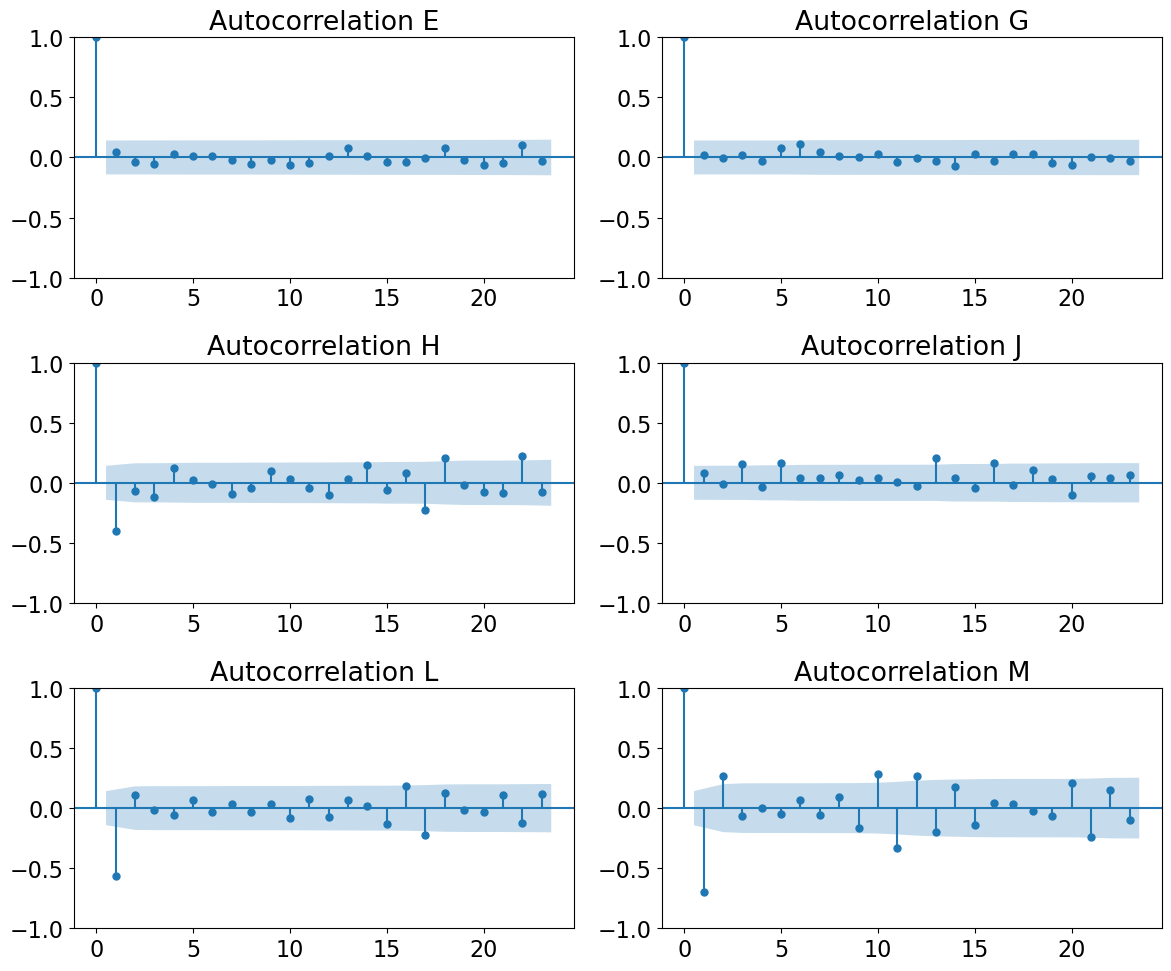

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

varian_list = ["E", "G", "H", "J", "L", "M"]
axes = axes.flatten()

for i, varian in enumerate(varian_list):
    if varian in df_weekly_varian_diff.columns:
        plot_acf(df_weekly_varian_diff[varian].dropna(), ax=axes[i], title=f"Autocorrelation {varian}")

plt.tight_layout()
plt.show()

- E, G, dan J tidak ada lag signifikan setelah lag 1 yg menunjukkan tidak ada tren atau musiman yang kuat
- H, L, ACF drop tajam di lag 1
- M, nilai korelasi di beberapa lag masih cukup tinggi meskipun dalam batas biru, mungkin ada sedikit efek musiman atau pola residual dari differencing

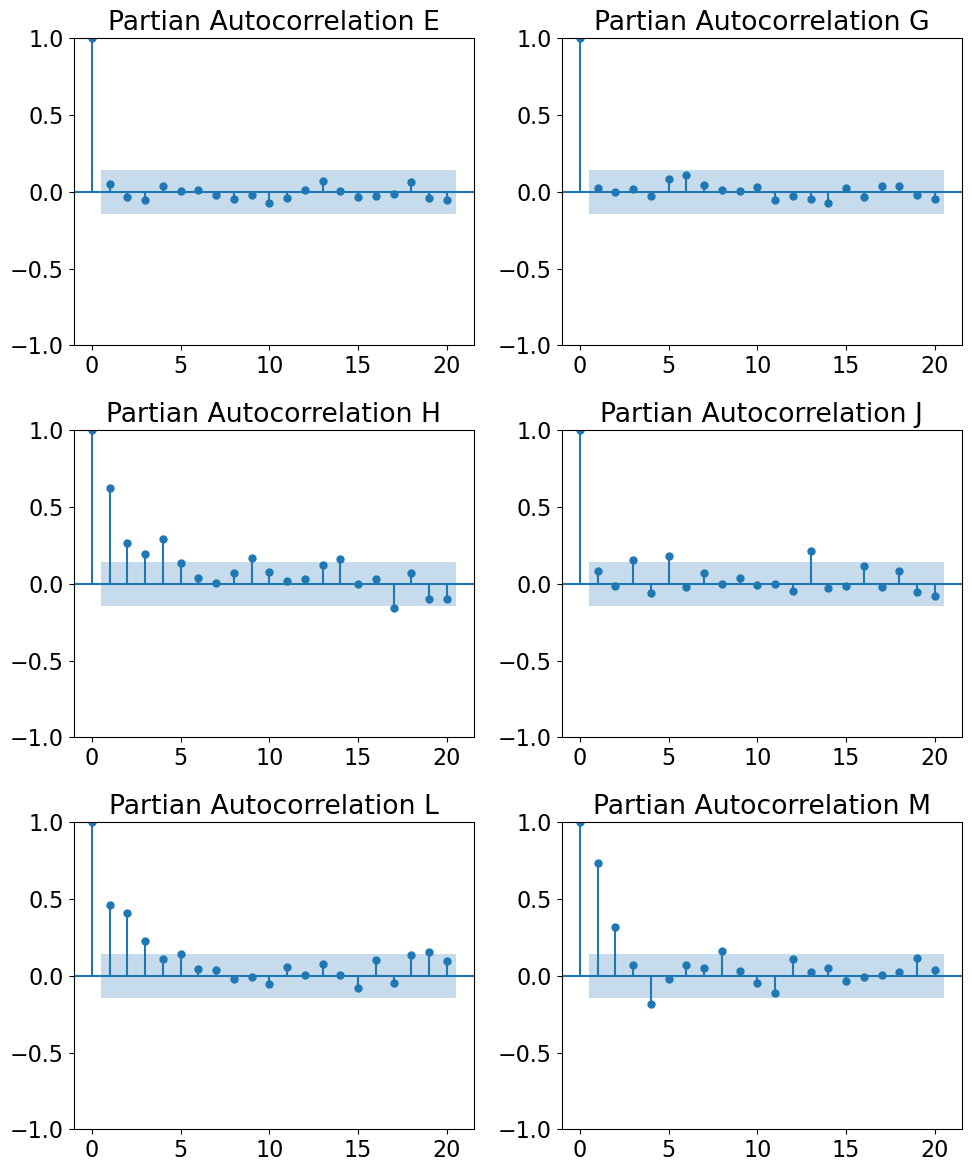

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
axes = axes.flatten()

for i, varian in enumerate(varian_list):
    if varian in df_weekly_varian.columns:
        plot_pacf(df_weekly_varian[varian], lags=20, ax=axes[i])
        axes[i].set_title(f"Partian Autocorrelation {varian}")

plt.tight_layout()
plt.show()

- E & G, PACF langsung turun setelah lag ke-1 pola AR(1), artinya hanya ada hubungan kuat dengan satu lag sebelumnya
- H & M, memiliki autokorelasi yang signifikan pada lag 1, 2, dan 3, AR(2) atau AR(3)
- J, menunjukkan beberapa lag awal yang signifikan AR(1)
- L, memiliki beberapa lag signifikan hingga sekitar lag 4, AR(4).

In [48]:
df_weekly_varian

Varian Label,Year,Week,E,G,H,J,L,M,Date
0,2020,53,0,0,0,0,5,0,2020-12-28
1,2021,1,6,1,5,0,22,0,2021-01-04
2,2021,2,1,0,7,0,16,0,2021-01-11
3,2021,3,1,0,8,0,16,0,2021-01-18
4,2021,4,0,2,9,0,14,0,2021-01-25
...,...,...,...,...,...,...,...,...,...
187,2024,31,0,1,0,0,23,20,2024-07-29
188,2024,32,0,1,1,0,23,30,2024-08-05
189,2024,33,0,0,0,0,19,19,2024-08-12
190,2024,34,0,4,0,0,23,21,2024-08-19


#### Data Splitting

In [49]:
split_idx = int(0.8 * len(df_weekly_varian_diff))
df_train = df_weekly_varian_diff.iloc[:split_idx].copy()
df_test = df_weekly_varian_diff.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): ({len(df_train)}, {len(df_test)})")

(len(df_train), len(df_test)): (153, 39)


## Deploy Model

### ARMA

In [50]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)

order_list = list(itertls.product(p_space, q_space))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [51]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

  result = []

  for order in notebook.tqdm(order_list):
    try:
      model = SARIMAX(endog, order=(order[0], 0, order[1]), 
                      simple_differencing=False).fit(disp=False)
    except:
      continue 

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [52]:
best_aic_results = {}

for varian in ["E", "G", "H", "J", "L", "M"]:
    if varian in df_weekly_varian.columns:
        print(f"\nOptimizing ARMA for Varian {varian}...")
        result_df = optimize_ARMA(df_weekly_varian[varian], order_list)
        best_aic_results[varian] = result_df.iloc[0]
        print(result_df.head(5))


Optimizing ARMA for Varian E...


  0%|          | 0/16 [00:00<?, ?it/s]

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace

    (p,q)          AIC
0  (1, 1)  1219.643059
1  (1, 2)  1221.058095
2  (2, 1)  1221.087190
3  (3, 1)  1222.906639
4  (1, 3)  1222.968648

Optimizing ARMA for Varian G...


  0%|          | 0/16 [00:00<?, ?it/s]

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\

    (p,q)         AIC
0  (3, 3)   14.000000
1  (1, 1)  939.717954
2  (1, 2)  941.604167
3  (2, 1)  941.604274
4  (2, 2)  943.347264

Optimizing ARMA for Varian H...


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/16 [00:00<?, ?it/s]

    (p,q)         AIC
0  (1, 1)  838.105788
1  (1, 2)  838.153420
2  (2, 1)  838.384052
3  (3, 1)  839.428742
4  (1, 3)  839.943507

Optimizing ARMA for Varian J...


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/16 [00:00<?, ?it/s]

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Progra

    (p,q)         AIC
0  (3, 2)  401.892947
1  (2, 3)  402.237945
2  (2, 2)  402.313802
3  (3, 3)  402.946597
4  (1, 1)  405.845622

Optimizing ARMA for Varian L...


  0%|          | 0/16 [00:00<?, ?it/s]

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


    (p,q)          AIC
0  (2, 1)  1387.447350
1  (1, 2)  1387.775681
2  (1, 1)  1387.948737
3  (1, 3)  1388.908325
4  (3, 1)  1389.091960

Optimizing ARMA for Varian M...


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/16 [00:00<?, ?it/s]

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive para

    (p,q)         AIC
0  (2, 2)  907.829453
1  (3, 3)  908.328678
2  (3, 0)  908.480399
3  (2, 1)  908.921766
4  (2, 3)  909.296017


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### ARIMA

In [53]:
# p_space = range(0, 4, 1)
# q_space = range(0, 4, 1)
# d = 2

# print(f"integration order, d = {d}")
# order_list = list(itertls.product(p_space, q_space))
# order_list

In [54]:
# def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
#                     enforce_stationarity: bool=True, 
#                     enforce_invertibility: bool=True) -> pd.DataFrame:

#   result = []
#   # warnings.filterwarnings("error")   # handling warnings as error
#   warnings.resetwarnings()     # to reset warnings

#   for order in notebook.tqdm(order_list):
#     print(f"{(order[0], order[1])}")
#     try:
#       model = SARIMAX(endog, order=(order[0], d, order[1]), 
#                       simple_differencing=False, 
#                       enforce_invertibility=enforce_invertibility,
#                       enforce_stationarity=enforce_stationarity).fit(disp=False)
#     except:
#       continue

#     aic = model.aic
#     result.append([order, aic])

  
#   result_df = pd.DataFrame(result)
#   # print(result_df.columns)
#   result_df.columns = ["(p,q)", "AIC"]

#   # Sort in ascending order, lower AIC is better
#   result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

#   return result_df

In [55]:
# best_aic_results = {}

# for varian in ["E", "G", "H", "J", "L", "M"]:
#     if varian in df_weekly_varian.columns:
#         print(f"\nOptimizing ARIMA for Varian {varian}...")
#         result_df = optimize_ARIMA(df_weekly_varian[varian], order_list)
#         best_aic_results[varian] = result_df.iloc[0]
#         print(result_df.head(5))